<a href="https://colab.research.google.com/github/Yaakov-Sternberg/USD-Capstone-Project-to-Predict-Preterm-Infant-Bradycardia-Events-/blob/main/USD_Capestone_V3_3_4_(CNN_LSTM_vs_TCN_Comparison%2C_with_ML%2C_CV%2C_L_T_Curves%2C_Optuna%2C_TB_Log%2C_by_G).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 131.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
Random seed set to 1234
Mounted at /content/drive
Found 10 ECG records: ['physionet.org/files/picsdb/1.0.0/infant10_ecg', 'physionet.org/files/picsdb/1.0.0/infant1_ecg', 'physionet.org/files/picsdb/1.0.0/infant2_ecg', 'physionet.org/files/picsdb/1.0.0/infant3_ecg', 'physionet.org/files/picsdb/1.0.0/infant4_ecg', 'physionet.org/files/picsdb/1.0.0/infant5_ecg', 'physionet.org/files/picsdb/1.0.0/infant6_ecg', '

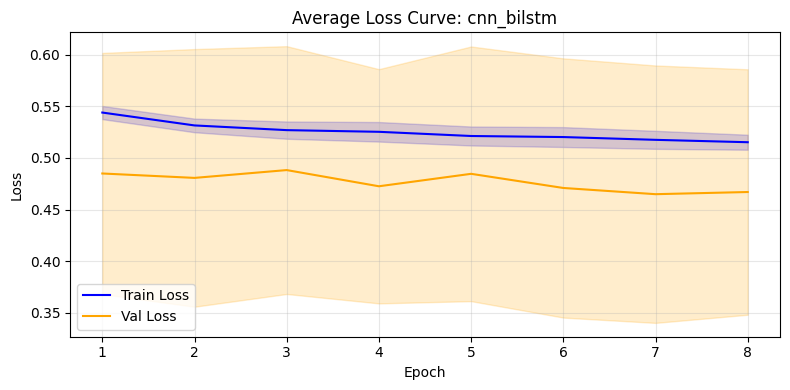

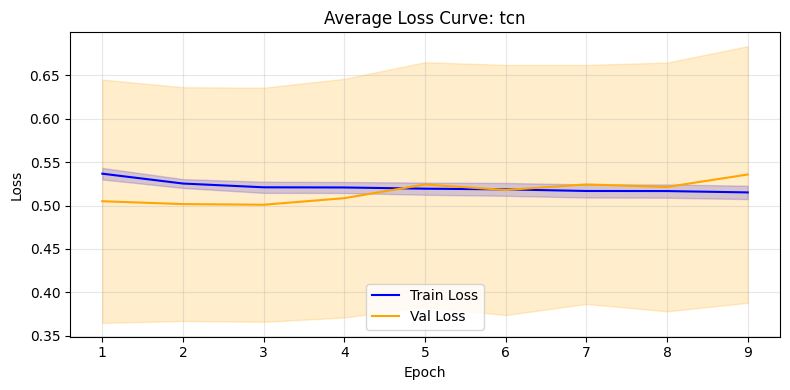

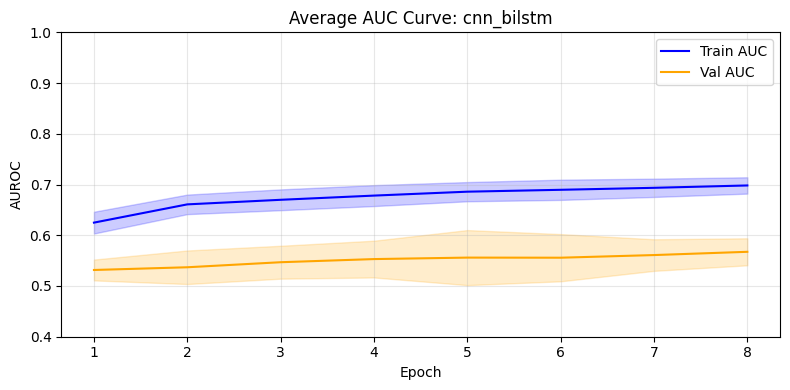

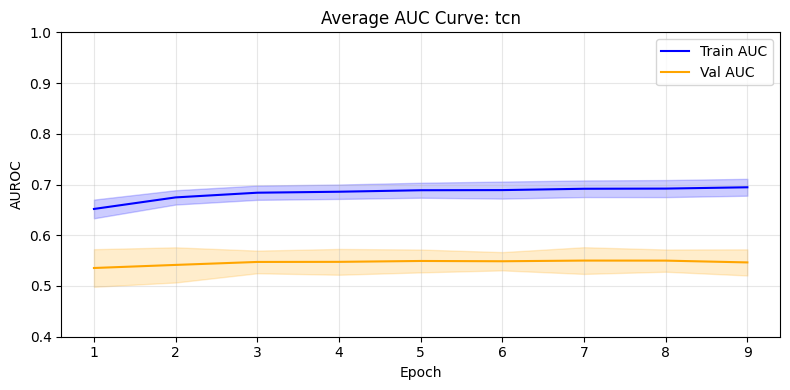

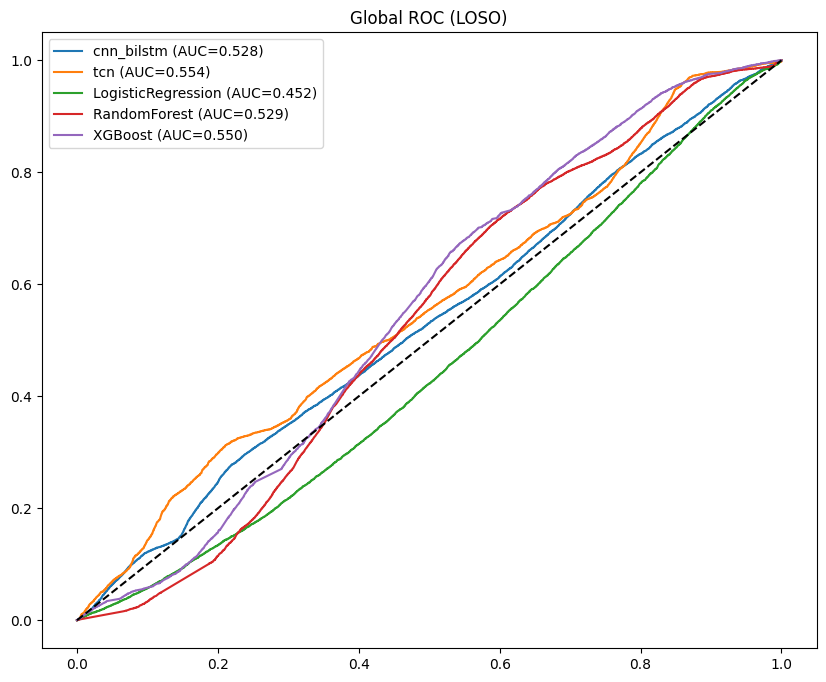

In [1]:
!pip install wfdb xgboost optuna tensorboard  --quiet

import os
import glob
import shutil
import random
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import json

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve
)
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import optuna
from scipy.special import expit

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import wfdb

"""Seed Everything"""

def set_seed(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

set_seed(1234)

"""Configs"""

# Change this each run:
EXPERIMENT_NAME = "v5_TCN"

# Paths
DRIVE_PATH = '/content/drive/MyDrive/picsdb'
LOCAL_PATH = '/content/picsdb_local'
OUTPUT_DIR = '/content/outputs'
CHECKPOINT_FILE = os.path.join(DRIVE_PATH, f'loso_results_{EXPERIMENT_NAME}.pkl')
TENSORBOARD_DIR = os.path.join(OUTPUT_DIR, f'runs_{EXPERIMENT_NAME}')

# Data parameters
FS_GRID = 2.0
WINDOW_LEN = 120.0
HORIZON = 60.0
STRIDE = 15.0
STRIDE_POSITIVE = 2.5
HR_CLIP_MIN = 40.0
HR_CLIP_MAX = 220.0

# Oversampling
USE_OVERSAMPLING = True
TARGET_POSITIVE_RATIO = 0.25

# Model parameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
N_EPOCHS = 30 # Changed from 25 for v4
PATIENCE = 7 # Changed from 15 for v4
GRAD_CLIP = 1.0
OPTUNA_TRIALS = 10

# Regularization / architecture
DROPOUT_P = 0.4   # was 0.3 (changed in v4)
WEIGHT_DECAY = 1e-3  # was 1e-4 (changed in v4)

"""Get data from Google Drive"""

try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    os.makedirs(TENSORBOARD_DIR, exist_ok=True)
    if os.path.exists(LOCAL_PATH):
        shutil.rmtree(LOCAL_PATH)
    if os.path.exists(DRIVE_PATH):
        if not os.path.exists(LOCAL_PATH):
             shutil.copytree(DRIVE_PATH, LOCAL_PATH)
    else:
        print(f"Warning: DRIVE_PATH {DRIVE_PATH} not found.")
        os.makedirs(LOCAL_PATH, exist_ok=True)
except ImportError:
    print("Not running in Colab, assuming local setup.")
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    os.makedirs(TENSORBOARD_DIR, exist_ok=True)

"""Data Loading functions"""

def load_hr_series(rec_ecg_rel, base_dir=LOCAL_PATH):
    rec_path = os.path.join(base_dir, rec_ecg_rel)
    header = wfdb.rdheader(rec_path)
    fs = header.fs
    brady_ann = wfdb.rdann(rec_path, 'atr')
    brady_times = np.array(brady_ann.sample) / fs
    r_ann = wfdb.rdann(rec_path, 'qrsc')
    r_times = np.array(r_ann.sample) / fs
    RR = np.diff(r_times)
    hr_times = r_times[1:]
    HR = 60.0 / RR
    return hr_times, HR, brady_times

def load_resp_waveform(rec_ecg_rel, base_dir=LOCAL_PATH):
    dirname, basename = os.path.split(rec_ecg_rel)
    infant_prefix = basename.split("_")[0]
    resp_basename = infant_prefix + "_resp"
    resp_rel = os.path.join(dirname, resp_basename)
    resp_path = os.path.join(base_dir, resp_rel)
    resp_record = wfdb.rdrecord(resp_path)
    fs_resp = resp_record.fs
    resp_signal = resp_record.p_signal[:, 0]
    t_resp = np.arange(len(resp_signal)) / fs_resp
    return t_resp, resp_signal

def resample_hr_and_resp(hr_times, HR, t_resp, resp_signal):
    HR_clip = np.clip(HR, HR_CLIP_MIN, HR_CLIP_MAX)
    t_start = max(hr_times[0], t_resp[0])
    t_end = min(hr_times[-1], t_resp[-1])
    t_grid = np.arange(t_start, t_end, 1.0 / FS_GRID)
    hr_grid = np.interp(t_grid, hr_times, HR_clip)
    resp_grid = np.interp(t_grid, t_resp, resp_signal)
    return t_grid, hr_grid, resp_grid

def make_hr_resp_windows(t_grid, hr_grid, resp_grid, brady_times):
    brady_times = np.asarray(brady_times)
    L = int(WINDOW_LEN * FS_GRID)
    step_neg = int(STRIDE * FS_GRID)
    step_pos = int(STRIDE_POSITIVE * FS_GRID)
    horizon_steps = int(HORIZON * FS_GRID)
    X, y = [], []
    max_start = len(t_grid) - L - horizon_steps
    positive_regions = []
    for brady_time in brady_times:
        start_range_begin = max(0, int((brady_time - HORIZON - WINDOW_LEN) * FS_GRID))
        start_range_end = min(max_start, int((brady_time - HORIZON) * FS_GRID))
        if start_range_end > start_range_begin:
            positive_regions.append((start_range_begin, start_range_end))
    if positive_regions:
        positive_regions.sort()
        merged = [positive_regions[0]]
        for start, end in positive_regions[1:]:
            if start <= merged[-1][1]:
                merged[-1] = (merged[-1][0], max(merged[-1][1], end))
            else:
                merged.append((start, end))
        positive_regions = merged
    processed_indices = set()
    for region_start, region_end in positive_regions:
        for start_idx in range(region_start, region_end, step_pos):
            if start_idx in processed_indices or start_idx > max_start:
                continue
            hr_win = hr_grid[start_idx:start_idx + L]
            resp_win = resp_grid[start_idx:start_idx + L]
            has_brady = np.any((brady_times >= t_grid[start_idx] + WINDOW_LEN) & (brady_times < t_grid[start_idx] + WINDOW_LEN + HORIZON))
            X.append(np.stack([hr_win, resp_win], axis=0))
            y.append(int(has_brady))
            processed_indices.add(start_idx)
    for start_idx in range(0, max_start, step_neg):
        if start_idx in processed_indices: continue
        if any(start <= start_idx < end for start, end in positive_regions): continue
        hr_win = hr_grid[start_idx:start_idx + L]
        resp_win = resp_grid[start_idx:start_idx + L]
        has_brady = np.any((brady_times >= t_grid[start_idx] + WINDOW_LEN) & (brady_times < t_grid[start_idx] + WINDOW_LEN + HORIZON))
        X.append(np.stack([hr_win, resp_win], axis=0))
        y.append(int(has_brady))
    return np.stack(X), np.array(y, dtype=np.int64)

def process_infant_ecg_resp(rec_ecg_rel):
    hr_times, HR, brady_times = load_hr_series(rec_ecg_rel)
    t_resp, resp_sig = load_resp_waveform(rec_ecg_rel)
    t_grid, hr_grid, resp_grid = resample_hr_and_resp(hr_times, HR, t_resp, resp_sig)
    X, y = make_hr_resp_windows(t_grid, hr_grid, resp_grid, brady_times)
    return X, y

hea_files = glob.glob(os.path.join(LOCAL_PATH, "**", "*.hea"), recursive=True)
record_names = [os.path.relpath(os.path.splitext(p)[0], LOCAL_PATH) for p in hea_files]
ecg_records = sorted([r for r in record_names if r.endswith("_ecg")])

print(f"Found {len(ecg_records)} ECG records: {ecg_records}")

all_X, all_y, all_infant_ids = [], [], []
for rec in ecg_records:
    try:
        X_i, y_i = process_infant_ecg_resp(rec)
        infant_id = os.path.basename(rec).split("_")[0]
        all_X.append(X_i)
        all_y.append(y_i)
        all_infant_ids.append(np.full_like(y_i, infant_id, dtype=object))
        print(f"  Success {infant_id}: {len(y_i)} windows, {y_i.sum()} positive events")
    except Exception as e:
        print(f"  Failed {rec}: {e}")
X_all = np.concatenate(all_X, axis=0)
y_all = np.concatenate(all_y, axis=0)
infant_ids = np.concatenate(all_infant_ids, axis=0)

"""Model Definitions"""

class CNNLSTMModel(nn.Module):
    def __init__(self, n_channels=2, lstm_hidden_size=32, lstm_num_layers=1, dropout_p=0.5):
        super().__init__()
        # Reduceding capacity for V4 to reduce overfitting
        self.cnn = nn.Sequential(
            nn.Conv1d(n_channels, 16, 5, padding=2), nn.BatchNorm1d(16), nn.ReLU(),
            nn.Conv1d(16, 32, 3, padding=1), nn.BatchNorm1d(32), nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.lstm = nn.LSTM(32, lstm_hidden_size, lstm_num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Sequential(
            nn.Linear(2 * lstm_hidden_size, 32), nn.ReLU(),
            nn.Dropout(dropout_p), nn.Linear(32, 1)
        )
    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        lstm_out, (h_n, c_n) = self.lstm(x)
        h_last = torch.cat([h_n[-2, :, :], h_n[-1, :, :]], dim=1)
        return self.fc(self.dropout(h_last)).squeeze(1)

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x): return x[..., :-self.chomp_size] if self.chomp_size > 0 else x

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        self.network = nn.Sequential(*layers)
    def forward(self, x): return self.network(x)

class TCNModel(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        self.tcn = TemporalConvNet(num_inputs, num_channels, kernel_size, dropout)
        self.fc = nn.Linear(num_channels[-1], 1)
    def forward(self, x):
        y = self.tcn(x)
        return self.fc(y.mean(dim=2)).squeeze(-1)

class HRRespDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

def get_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test):
    train_dataset = HRRespDataset(X_train, y_train)
    val_dataset = HRRespDataset(X_val, y_val)
    test_dataset = HRRespDataset(X_test, y_test)

    # GPU optimization: parallel data loading
    num_workers = 2 if torch.cuda.is_available() else 0

    if USE_OVERSAMPLING and y_train.sum() > 0:
        n_pos = y_train.sum()
        n_neg = len(y_train) - n_pos
        scale_factor = (TARGET_POSITIVE_RATIO / (1 - TARGET_POSITIVE_RATIO)) / (n_pos / n_neg)
        weights = np.where(y_train == 1, scale_factor, 1.0)
        sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights), replacement=True)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler,
                                  pin_memory=True, num_workers=num_workers)
    else:
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                  pin_memory=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                            pin_memory=True, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                             pin_memory=True, num_workers=num_workers)
    return train_loader, val_loader, test_loader


"""Training Engine"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def eval_epoch(model, data_loader, criterion, device):
    model.eval()
    all_labels, all_logits = [], []
    total_loss, n_samples = 0.0, 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            total_loss += loss.item() * y_batch.size(0)
            n_samples += y_batch.size(0)
            all_labels.append(y_batch.cpu().numpy())
            all_logits.append(logits.cpu().numpy())
    all_labels = np.concatenate(all_labels)
    all_logits = np.concatenate(all_logits)
    probs = expit(all_logits)
    try:
        auroc = roc_auc_score(all_labels, probs)
        auprc = average_precision_score(all_labels, probs)
    except ValueError:
        auroc = auprc = float("nan")
    return total_loss / n_samples, auroc, auprc, all_labels, probs

def train_fold_model(model_name, train_loader, val_loader, test_loader, device, fold_name, tensorboard_writer=None):
    set_seed(1234)
    if model_name == "cnn_bilstm":
        model = CNNLSTMModel(dropout_p=DROPOUT_P)
    elif model_name == "tcn":
        model = TCNModel(2, [32, 64, 128], dropout=DROPOUT_P)
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

    best_val_auroc = -1
    best_state = None
    patience_counter = 0
    train_loss_history, val_loss_history = [], []
    train_auc_history, val_auc_history = [], []

    for epoch in range(1, N_EPOCHS + 1):
        model.train()
        batch_losses = []

        # Track training predictions for this epoch to calc Train AUC
        train_labels_epoch = []
        train_logits_epoch = []

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()
            batch_losses.append(loss.item())

            # Collect for epoch-level metrics
            train_labels_epoch.append(y_batch.detach().cpu().numpy())
            train_logits_epoch.append(logits.detach().cpu().numpy())

        avg_train_loss = np.mean(batch_losses)

        # Calculate Train AUC
        train_labels_cat = np.concatenate(train_labels_epoch)
        train_probs_cat = expit(np.concatenate(train_logits_epoch))
        try:
            train_auroc = roc_auc_score(train_labels_cat, train_probs_cat)
        except:
            train_auroc = 0.5

        val_loss, val_auroc, val_auprc, _, _ = eval_epoch(model, val_loader, criterion, device)

        train_loss_history.append(avg_train_loss)
        val_loss_history.append(val_loss)
        train_auc_history.append(train_auroc)
        val_auc_history.append(val_auroc)

        if tensorboard_writer:
            tensorboard_writer.add_scalars(f'{model_name}_{fold_name}/Loss', {'Train': avg_train_loss, 'Val': val_loss}, epoch)
            tensorboard_writer.add_scalars(f'{model_name}_{fold_name}/AUROC', {'Train': train_auroc, 'Val': val_auroc}, epoch)

        scheduler.step(val_auroc)
        if val_auroc > best_val_auroc:
            best_val_auroc = val_auroc
            best_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE: break

    if best_state: model.load_state_dict(best_state)
    torch.cuda.empty_cache()
    test_loss, test_auroc, test_auprc, test_labels, test_probs = eval_epoch(model, test_loader, criterion, device)

    return {
        "Fold": fold_name, "Model": model_name,
        "Test_AUROC": test_auroc, "Test_AUPRC": test_auprc,
        "Best_Val_AUROC": best_val_auroc,
        "Test_Labels": test_labels, "Test_Probs": test_probs,
        "Train_Loss_History": train_loss_history, "Val_Loss_History": val_loss_history,
        "Train_AUC_History": train_auc_history, "Val_AUC_History": val_auc_history
    }


def train_ml_model(model_type, X_train, y_train, X_test, y_test, fold_name):
    """Train ML model with fixed, conservative hyperparameters."""
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    scale_pos = n_neg / n_pos if n_pos > 0 else 1.0

    if model_type == "LogisticRegression":
        clf = LogisticRegression(
            C=0.1,
            class_weight='balanced',
            max_iter=1000,
            solver='liblinear',
            random_state=1234
        )
    elif model_type == "RandomForest":
        clf = RandomForestClassifier(
            n_estimators=100,
            max_depth=5,
            min_samples_leaf=10,
            class_weight='balanced',
            n_jobs=-1,
            random_state=1234
        )
    elif model_type == "XGBoost":
        clf = XGBClassifier(
            n_estimators=50,
            max_depth=3,
            learning_rate=0.1,
            min_child_weight=10,
            reg_alpha=1.0,
            reg_lambda=1.0,
            scale_pos_weight=scale_pos,
            eval_metric='logloss',
            n_jobs=-1,
            random_state=1234
        )

    clf.fit(X_train_flat, y_train)

    probs_test = clf.predict_proba(X_test_flat)[:, 1]
    probs_train = clf.predict_proba(X_train_flat)[:, 1]

    try:
        auroc_test = roc_auc_score(y_test, probs_test)
        auprc_test = average_precision_score(y_test, probs_test)
        auroc_train = roc_auc_score(y_train, probs_train)
    except:
        auroc_test, auprc_test, auroc_train = float("nan"), float("nan"), float("nan")

    return {
        "Fold": fold_name, "Model": model_type,
        "Test_AUROC": auroc_test, "Test_AUPRC": auprc_test,
        "Train_AUROC": auroc_train,
        "Test_Labels": y_test, "Test_Probs": probs_test
    }


"""LOSO Loop"""

logo = LeaveOneGroupOut()
groups = infant_ids
unique_subjects = np.unique(groups)
ml_models_list = ["LogisticRegression", "RandomForest", "XGBoost"]
dl_models_list = ["cnn_bilstm", "tcn"]
all_models = dl_models_list + ml_models_list

if os.path.exists(CHECKPOINT_FILE):
    print(f"Found existing checkpoint. Loading...")
    with open(CHECKPOINT_FILE, 'rb') as f:
        loso_results = pickle.load(f)
    counts = {}
    for res in loso_results:
        sub = res['Fold']
        counts[sub] = counts.get(sub, 0) + 1
    completed_subjects = {sub for sub, count in counts.items() if count >= len(all_models)}
else:
    loso_results = []
    completed_subjects = set()

writer = SummaryWriter(log_dir=TENSORBOARD_DIR)
aggregated_preds = {m: {"labels": [], "probs": []} for m in all_models}
loss_histories = {m: {"train": [], "val": []} for m in dl_models_list}
auc_histories = {m: {"train": [], "val": []} for m in dl_models_list}

for res in loso_results:
    m_name = res["Model"]
    if m_name in aggregated_preds:
        aggregated_preds[m_name]["labels"].append(res["Test_Labels"])
        aggregated_preds[m_name]["probs"].append(res["Test_Probs"])

for fold_idx, (train_val_idx, test_idx) in enumerate(logo.split(X_all, y_all, groups)):
    test_subject = np.unique(groups[test_idx])[0]
    if test_subject in completed_subjects:
        print(f"Subject {test_subject} already processed. Skipping.")
        continue

    print(f"\nProcessing Fold {fold_idx+1}/{len(unique_subjects)} (Test Subject: {test_subject})")
    X_train_val, y_train_val, g_train_val = X_all[train_val_idx], y_all[train_val_idx], groups[train_val_idx]
    X_test, y_test = X_all[test_idx], y_all[test_idx]

    inner_logo = LeaveOneGroupOut()
    train_idx, val_idx = next(inner_logo.split(X_train_val, y_train_val, g_train_val))
    X_train, y_train = X_train_val[train_idx], y_train_val[train_idx]
    X_val, y_val = X_train_val[val_idx], y_train_val[val_idx]

    scaler = StandardScaler()
    N, C, T = X_train.shape
    X_train_s = scaler.fit_transform(X_train.reshape(N, -1)).reshape(N, C, T)
    X_val_s = scaler.transform(X_val.reshape(X_val.shape[0], -1)).reshape(X_val.shape[0], C, T)
    X_test_s = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape[0], C, T)

    train_dl, val_dl, test_dl = get_dataloaders(X_train_s, y_train, X_val_s, y_val, X_test_s, y_test)

    # DL Models
    for m_name in dl_models_list:
        res = train_fold_model(m_name, train_dl, val_dl, test_dl, device, test_subject, writer)
        loss_histories[m_name]["train"].append(np.array(res["Train_Loss_History"]))
        loss_histories[m_name]["val"].append(np.array(res["Val_Loss_History"]))
        auc_histories[m_name]["train"].append(np.array(res["Train_AUC_History"]))
        auc_histories[m_name]["val"].append(np.array(res["Val_AUC_History"]))

        # Use final epoch's training AUC for summary table
        res["Train_AUROC"] = res["Train_AUC_History"][-1]

        slim_res = {k: v for k, v in res.items() if "History" not in k}
        loso_results.append(slim_res)
        aggregated_preds[m_name]["labels"].append(res["Test_Labels"])
        aggregated_preds[m_name]["probs"].append(res["Test_Probs"])
        print(f"  {m_name.upper()} Test AUROC: {res['Test_AUROC']:.4f} | Train AUROC: {res['Train_AUROC']:.4f}")

    # Traditional ML Models
    X_train_ml = np.concatenate([X_train_s, X_val_s], axis=0)
    y_train_ml = np.concatenate([y_train, y_val], axis=0)

    # Concatenate groups corresponding to inner train & val sets
    g_train_ml = np.concatenate([g_train_val[train_idx], g_train_val[val_idx]], axis=0)

    for m_name in ml_models_list:
        res = train_ml_model(m_name, X_train_ml, y_train_ml, X_test_s, y_test, test_subject)
        loso_results.append(res)
        aggregated_preds[m_name]["labels"].append(res["Test_Labels"])
        aggregated_preds[m_name]["probs"].append(res["Test_Probs"])
        print(f"  {m_name} Test AUROC: {res['Test_AUROC']:.4f} | Train AUROC: {res['Train_AUROC']:.4f}")

    with open(CHECKPOINT_FILE, 'wb') as f:
        pickle.dump(loso_results, f)

writer.close()

"""Analysis & Plotting"""

df_results = pd.DataFrame(loso_results)
df_summary = df_results.drop(columns=["Test_Labels", "Test_Probs"], errors='ignore')
# Calculate Gap
if "Train_AUROC" in df_summary.columns:
    df_summary["Overfit_Gap"] = df_summary["Train_AUROC"] - df_summary["Test_AUROC"]

print(f"\n{'='*60}\nLOSO-CV Results Summary\n{'='*60}")
print(df_summary[["Fold", "Model", "Train_AUROC", "Test_AUROC", "Overfit_Gap"]])

print("\n" + "="*60)
print("Aggregated Performance (Mean ± Std across LOSO folds)")
print("="*60)

agg_dict = {
    "Train_AUROC": ["mean", "std"],
    "Test_AUROC": ["mean", "std"],
    "Overfit_Gap": ["mean", "std"]
}
if "Test_AUPRC" in df_summary.columns:
    agg_dict["Test_AUPRC"] = ["mean", "std"]

summary_stats = df_summary.groupby("Model").agg(agg_dict).round(3)
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
print(summary_stats)

# Plot Average Loss Curves with Standard Deviation Bands
for m_name in dl_models_list:
    train_hists = loss_histories[m_name]["train"]
    val_hists = loss_histories[m_name]["val"]

    if len(train_hists) == 0:
        continue

    # Find minimum length across all folds
    min_len = min(h.shape[0] for h in train_hists)

    # Stack arrays & compute statistics
    stacked_train = np.stack([h[:min_len] for h in train_hists])
    stacked_val = np.stack([h[:min_len] for h in val_hists])

    mean_train = stacked_train.mean(axis=0)
    std_train = stacked_train.std(axis=0)
    mean_val = stacked_val.mean(axis=0)
    std_val = stacked_val.std(axis=0)

    epochs = np.arange(1, min_len + 1)

    # Create plot
    plt.figure(figsize=(8, 4))

    # Training loss with shaded std band
    plt.plot(epochs, mean_train, label="Train Loss", color="blue")
    plt.fill_between(
        epochs,
        mean_train - std_train,
        mean_train + std_train,
        color="blue",
        alpha=0.2
    )

    # Validation loss with shaded std band
    plt.plot(epochs, mean_val, label="Val Loss", color="orange")
    plt.fill_between(
        epochs,
        mean_val - std_val,
        mean_val + std_val,
        color="orange",
        alpha=0.2
    )

    plt.title(f"Average Loss Curve: {m_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"loss_{m_name}_{EXPERIMENT_NAME}.png"), dpi=150)
    plt.show()

# Plot Average AUC Curves with std Bands
for m_name in dl_models_list:
    train_hists = auc_histories[m_name]["train"]
    val_hists = auc_histories[m_name]["val"]

    if len(train_hists) == 0:
        continue

    # Find minimum length across all folds
    min_len = min(h.shape[0] for h in train_hists)

    # Stack arrays and compute statistics
    stacked_train = np.stack([h[:min_len] for h in train_hists])
    stacked_val = np.stack([h[:min_len] for h in val_hists])

    mean_train = stacked_train.mean(axis=0)
    std_train = stacked_train.std(axis=0)
    mean_val = stacked_val.mean(axis=0)
    std_val = stacked_val.std(axis=0)

    epochs = np.arange(1, min_len + 1)

    # Create plot
    plt.figure(figsize=(8, 4))

    # Training AUC with shaded std band
    plt.plot(epochs, mean_train, label="Train AUC", color="blue")
    plt.fill_between(
        epochs,
        mean_train - std_train,
        mean_train + std_train,
        color="blue",
        alpha=0.2
    )

    # Validation AUC with shaded std band
    plt.plot(epochs, mean_val, label="Val AUC", color="orange")
    plt.fill_between(
        epochs,
        mean_val - std_val,
        mean_val + std_val,
        color="orange",
        alpha=0.2
    )

    plt.title(f"Average AUC Curve: {m_name}")
    plt.xlabel("Epoch")
    plt.ylabel("AUROC")
    plt.ylim(0.4, 1.0)  # AUC typically ranges from 0.5 (random) to 1.0
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"auc_curve_{m_name}_{EXPERIMENT_NAME}.png"), dpi=150)
    plt.show()

plt.figure(figsize=(10, 8))
for m_name in all_models:
    if len(aggregated_preds[m_name]["labels"]) == 0: continue
    y_true = np.concatenate(aggregated_preds[m_name]["labels"])
    y_prob = np.concatenate(aggregated_preds[m_name]["probs"])
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.plot(fpr, tpr, label=f'{m_name} (AUC={auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("Global ROC (LOSO)")
plt.savefig(os.path.join(OUTPUT_DIR, f"global_roc_{EXPERIMENT_NAME}.png"))
plt.show()

df_summary.to_csv(os.path.join(DRIVE_PATH, f"loso_summary_{EXPERIMENT_NAME}.csv"))